## Fine-tuning DETR on a custom dataset for object detection

In this notebook, we are going to fine-tune [DETR](https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/) (end-to-end object detection with Transformers) on a custom object detection dataset. The goal for the model is to recognize balloons in pictures.

* Original DETR paper: https://arxiv.org/abs/2005.12872
* Original DETR repo: https://github.com/facebookresearch/detr

Important note regarding **GPU memory**: `DetrFeatureExtractor` by default resizes each image to have a `min_size` of 800 pixels and a `max_size` of 1333 pixels (as these are the default values that DETR uses at *inference* time). Note that this can stress-test the memory of your GPU when *training* the model, as the images are flattened after sent through the convolutional backbone. The sequence length that is sent through the Transformer is typically of length (height*width/32^2). So if you consider an image of size (900, 900) for example, the sequence length is 900^2/32^2 = 791, which is larger than what NLP models like BERT use (512). It's advised to use a batch size of 2 on a single GPU. You can of course also initialize `DetrFeatureExtractor` with a smaller `size` and/or `max_size` to use bigger batches. 

Note regarding **augmentation**: DETR actually uses several image augmentations during training. One of them is **scale augmentation**: they set the `min_size` randomly to be one of [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800] as can be seen [here](https://github.com/facebookresearch/detr/blob/a54b77800eb8e64e3ad0d8237789fcbf2f8350c5/datasets/coco.py#L122). However, we are not going to add any of the augmentations that are used in the original implementation during training. It works fine without them.

Also big thanks to the creator of [this notebook](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb), which helped me a lot in understanding how to fine-tune DETR on a custom dataset.



## Set up environment

In [ ]:
import numpy as np

In [3]:
!git clone "https://github.com/starboi2000/Iris-Data.git" 

Cloning into 'Iris-Data.git''...
fatal: protocol ''https' is not supported


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git timm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 378kB 30.1MB/s 
     |████████████████████████████████| 901kB 39.1MB/s 
     |████████████████████████████████| 3.3MB 51.4MB/s 


In [1]:
!pip install -q pytorch-lightning

## Download + preprocess data

Here we download the balloon dataset, hosted on Github.

In [ ]:
!unzip '/content/drive/MyDrive/Drone.v1-20210703-353pm.coco.zip' > /dev/null

In [ ]:
# # download, decompress the data
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null  

The balloon dataset comes in the VIA annotation format. However, to prepare the annotations for the model, `DetrFeatureExtractor` expects them to be in COCO format. The following cell clones a Github repo that includes a function to convert them into COCO format.

In [ ]:
# !git clone https://github.com/woctezuma/VIA2COCO
# %cd VIA2COCO/
# !git checkout fixes

In [ ]:
# import convert as via2coco

# data_path = '/content/balloon/'

# first_class_index = 0

# for keyword in ['train', 'val']:

#   input_dir = data_path + keyword + '/'
#   input_json = input_dir + 'via_region_data.json'
#   categories = ['balloon']
#   super_categories = ['N/A']
#   output_json = input_dir + 'custom_' + keyword + '.json'

#   print('Converting {} from VIA format to COCO format'.format(input_json))

#   coco_dict = via2coco.convert(
#       imgdir=input_dir,
#       annpath=input_json,
#       categories=categories,
#       super_categories=super_categories,
#       output_file_name=output_json,
#       first_class_index=first_class_index,
#   )

In [ ]:
# %cd ..

## Create PyTorch dataset + dataloaders

Here we define a regular PyTorch dataset. Each item of the dataset is an image and corresponding annotations. Torchvision already provides a `CocoDetection` dataset, which we can use. We only add a feature extractor (`DetrFeatureExtractor`) to resize + normalize the images, and to turn the annotations (which are in COCO format) in the format that DETR expects. It will also resize the annotations accordingly.

In [ ]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "/content/train/_annotations.coco.json" if train else "/content/test/_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

Based on the class defined above, we create training and validation datasets.

In [ ]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='/content/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder='/content/test', feature_extractor=feature_extractor, train=False)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


As you can see, this dataset is tiny:

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 1130
Number of validation examples: 59


Let's verify an example by visualizing it. We can access the COCO API of the dataset by typing `train_dataset.coco`. 

Image n°940


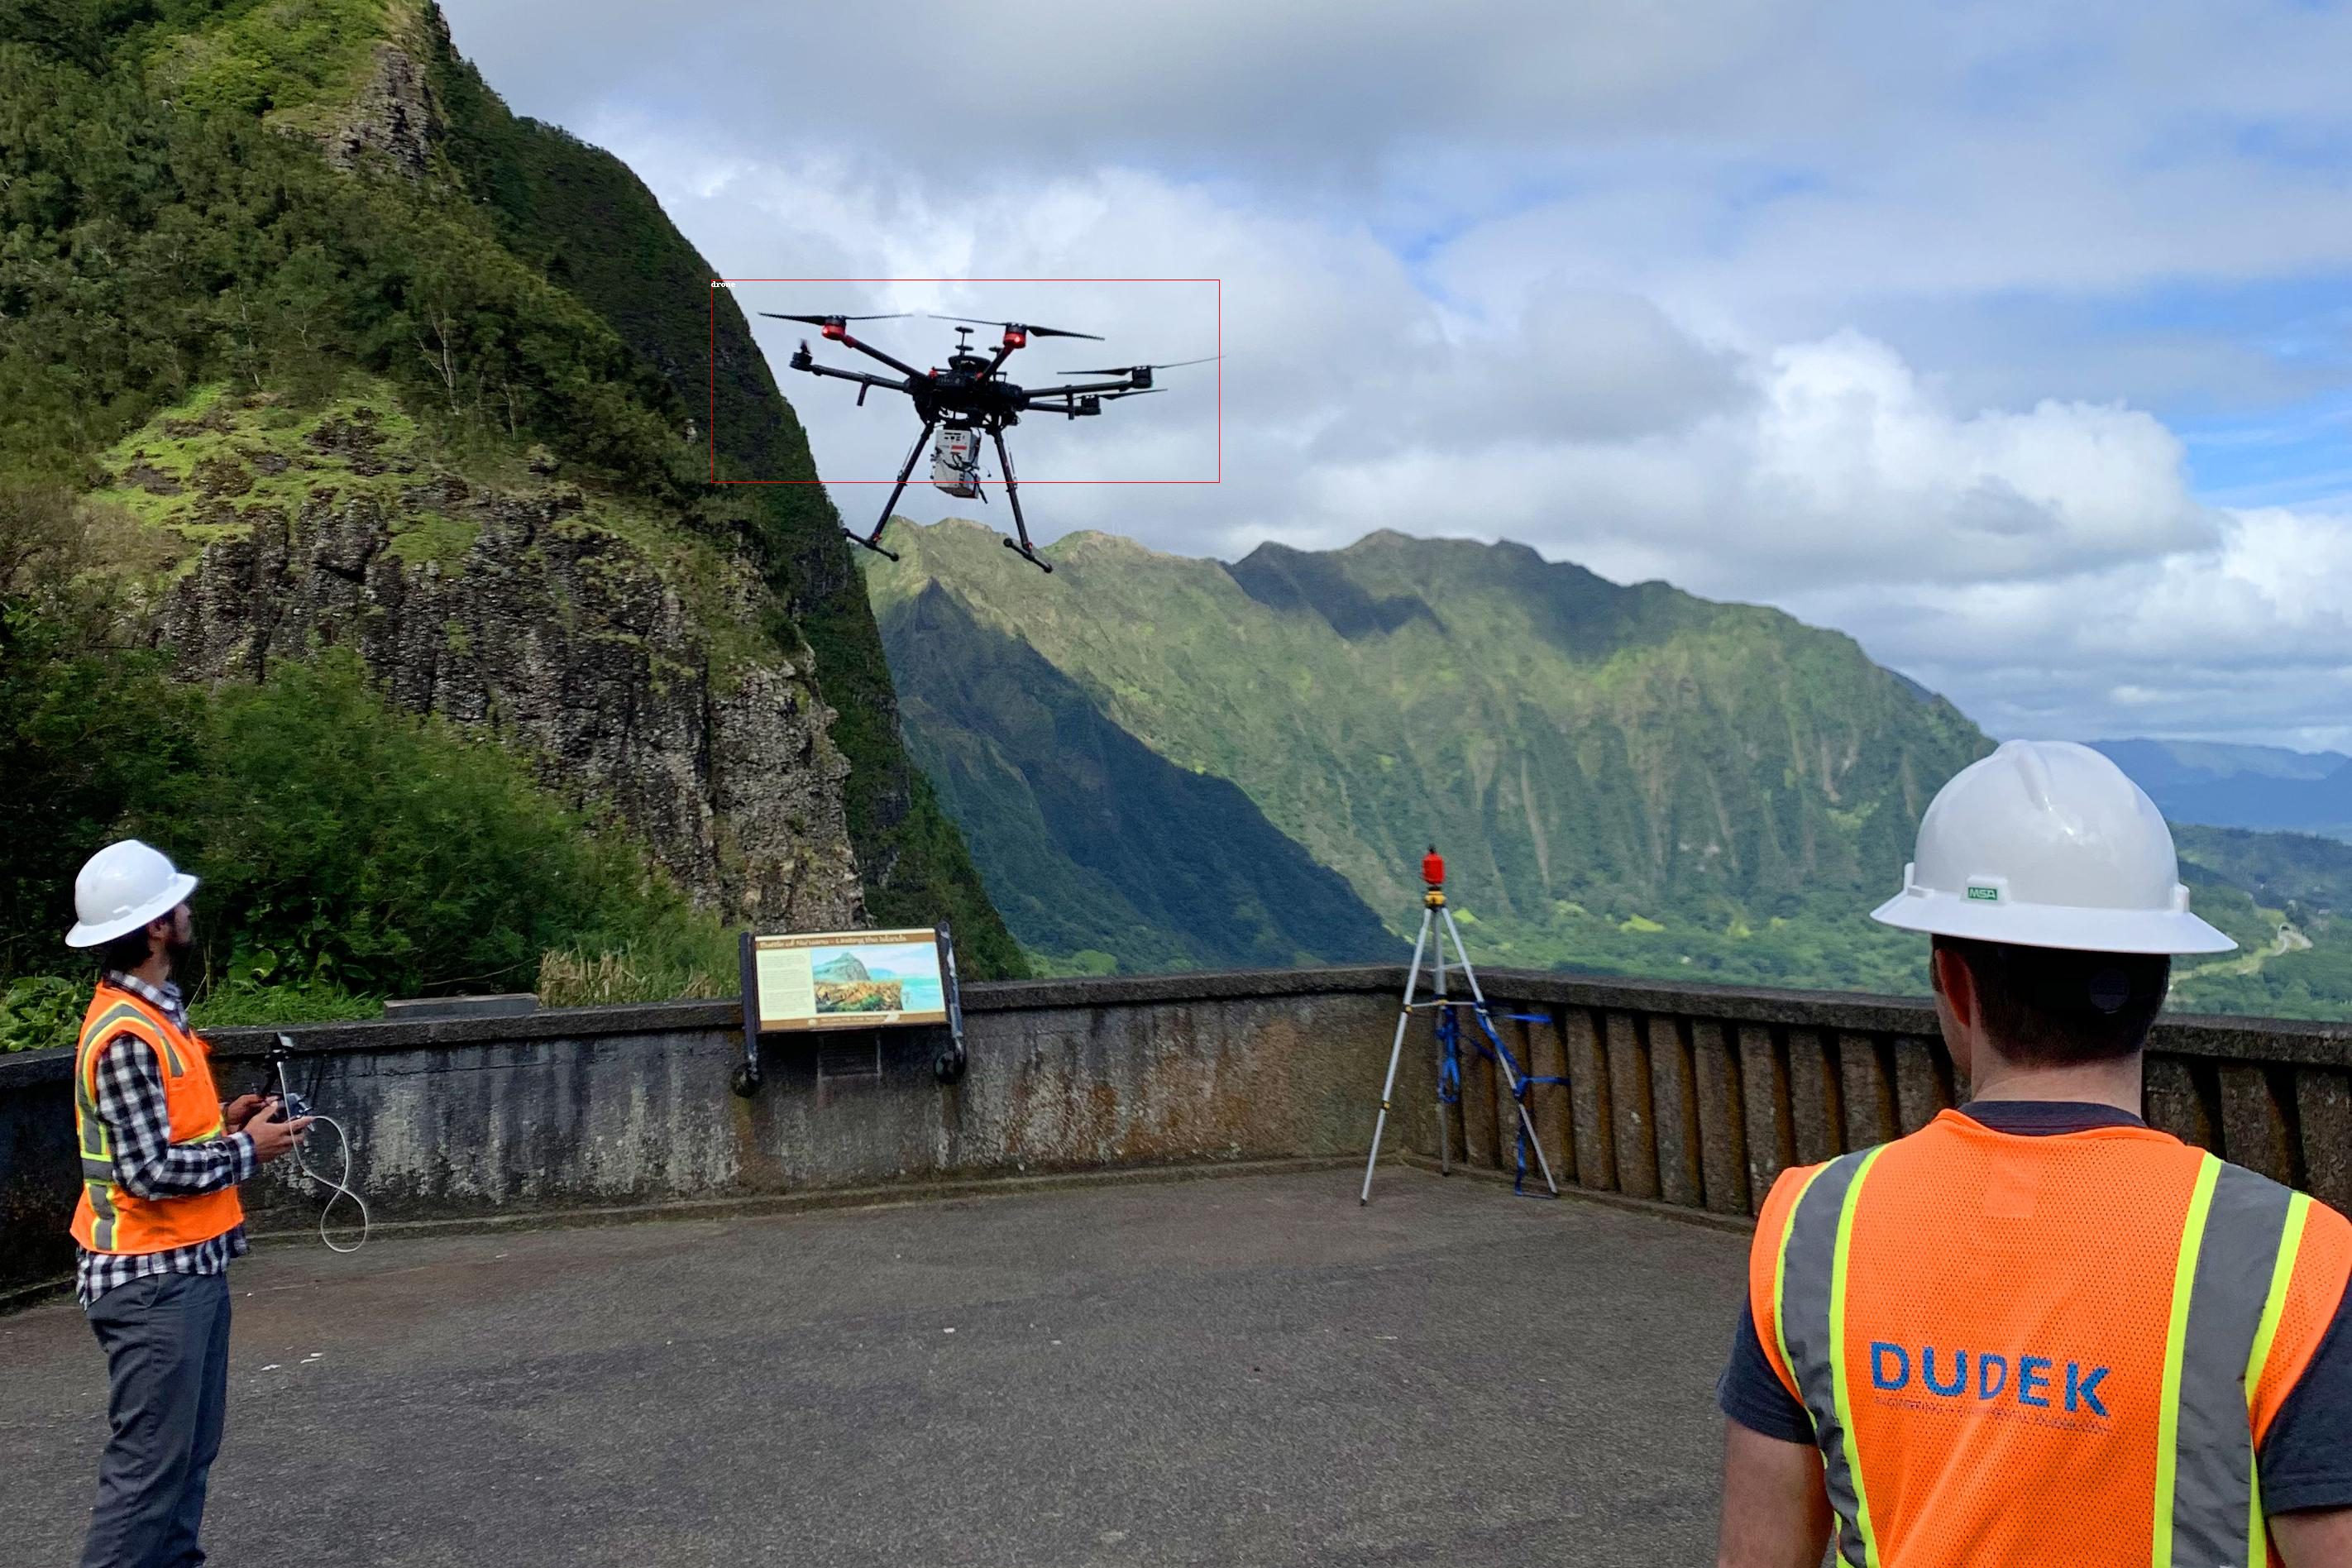

In [ ]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

Next, let's create corresponding dataloaders. We define a custom `collate_fn` to batch images together. As DETR resizes images to have a min size of 800 and a max size of 1333, images can have different sizes. We pad images (`pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask` to indicate which pixels are real (1)/which are padding (0).  

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

Let's verify the keys of a single batch:

In [ ]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

Let's verify the shape of the `pixel_values`, and check the `target`::

In [ ]:
pixel_values, target = train_dataset[0]

In [ ]:
pixel_values.shape

torch.Size([3, 800, 1308])

In [ ]:
print(target)

{'boxes': tensor([[0.6568, 0.2681, 0.6229, 0.4022]]), 'class_labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([262151.7500]), 'iscrowd': tensor([0]), 'orig_size': tensor([ 731, 1196]), 'size': tensor([ 800, 1308])}


## Train the model using PyTorch Lightning

Here we define a `LightningModule`, which is an nn.Module with some extra functionality.

For more information regarding PyTorch Lightning, I recommend the [docs](https://pytorch-lightning.readthedocs.io/en/latest/?_ga=2.35105442.2002381006.1623231889-1738348008.1615553774) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/lightning-tutorials/tree/aeae8085b48339e9bd9ab61d81cc0dc8b0d48f9c/.notebooks/starters). 

In [ ]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
         state_dict = model.state_dict()
         # Remove class weights
         del state_dict["class_labels_classifier.weight"]
         del state_dict["class_labels_classifier.bias"]
         # define new model with custom class classifier
         config = DetrConfig.from_pretrained("facebook/detr-resnet-50", num_labels=len(id2label))
         model = DetrForObjectDetection(config)
         model.load_state_dict(state_dict, strict=False)
         self.model = model

         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

As PyTorch Lightning by default logs to Tensorboard, let's start it:

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Here we define the model, and verify the outputs.

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, roundi

In [ ]:
outputs.logits.shape

torch.Size([4, 100, 3])

Next, let's train! We train for a maximum of 300 training steps, and also use gradient clipping. You can refresh Tensorboard above to check the various losses.

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=1, gradient_clip_val=0.1, max_epochs=10)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.038   Total estimated model params size (MB)


In [ ]:
import torch

In [ ]:
torch.save(model, '/content/drive/MyDrive/model2.pth')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model.pth')

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/od')

In [ ]:
# model = torch.load('/content/drive/MyDrive/model2.pth')
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))
# model = torch.load('/content/drive/MyDrive/detr_4.pth', map_location='cpu',)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


<All keys matched successfully>

## Evaluate the model

Finally, we evaluate the model on the validation set. The original DETR repo has some nice evaluation tools that we will use.

They are based on the `CocoEvaluator` class from torchvision, which in turn is based on [this](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py).

In [ ]:
! git clone https://github.com/facebookresearch/detr.git
%cd /content/detr

Cloning into 'detr'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 247 (delta 0), reused 3 (delta 0), pack-reused 243
Receiving objects: 100% (247/247), 12.84 MiB | 34.43 MiB/s, done.
Resolving deltas: 100% (130/130), done.
/content/detr


Let's first load the ground truth COCO dataset:

In [ ]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

Let's run the evaluation:

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)



Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.801
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.577
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.550
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

## Inference (+ visualization)

Let's visualize the predictions of DETR on the first image of the validation set.

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[35]

In [ ]:
pixel_values
target

{'area': tensor([170096.9531]),
 'boxes': tensor([[0.5583, 0.3404, 0.5467, 0.4038]]),
 'class_labels': tensor([1]),
 'image_id': tensor([35]),
 'iscrowd': tensor([0]),
 'orig_size': tensor([ 520, 1200]),
 'size': tensor([ 578, 1333])}

In [ ]:
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

In [ ]:
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [ ]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.7):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

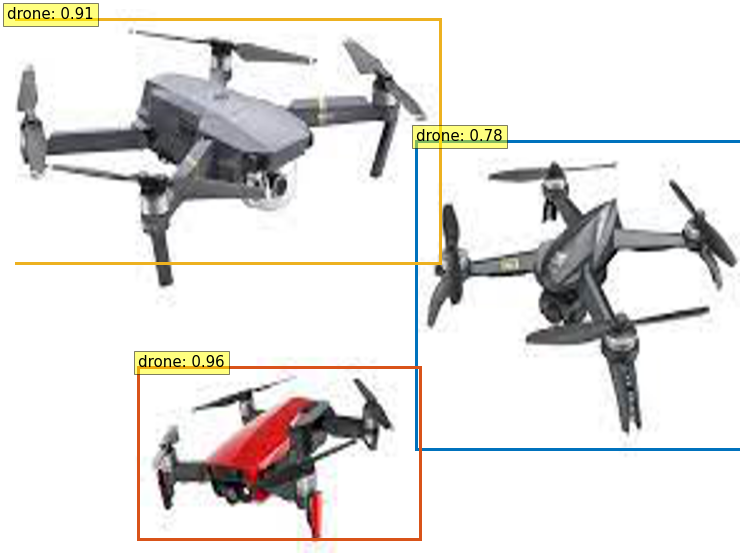

In [ ]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/test', image['file_name']))

visualize_predictions(image, outputs)

###Prediction on a URL or a random picture

In [ ]:
import requests
import torchvision.transforms as T

In [ ]:
url  = input()

https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRY7IHw4OStQUuoD_kJxl_YTX4cqHl_goqPQg&usqp=CAU


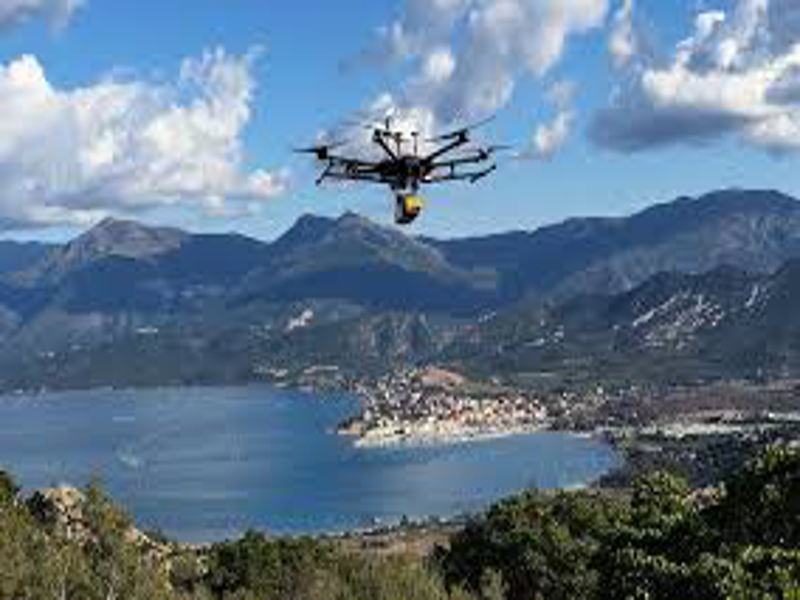

In [ ]:
img = Image.open(requests.get(url, stream=True).raw).resize((800,600)).convert('RGB')
img

In [ ]:
pixel_values = img

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
pixel_values = transform(pixel_values).unsqueeze(0).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 600, 800])


In [ ]:
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [ ]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.7):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

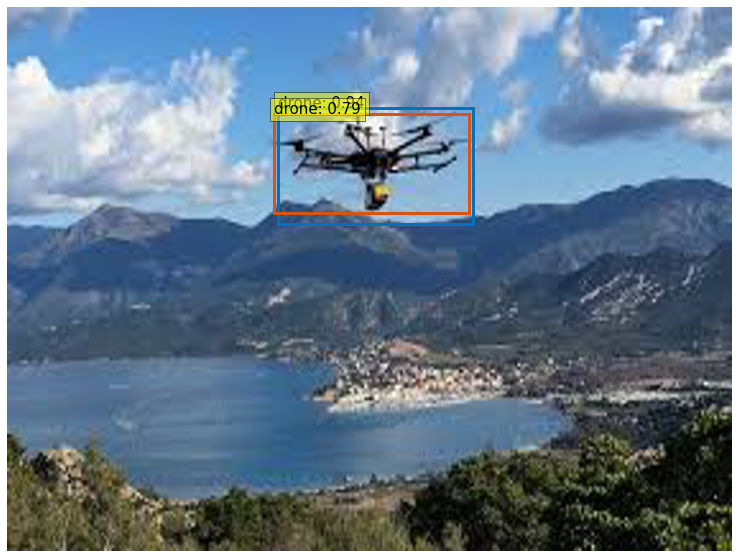

In [ ]:
visualize_predictions(img, outputs)